In [162]:
%reset -f
%clear
import torch
import numpy as np
from matplotlib import pyplot as plt
import skimage
from scipy.signal import convolve2d
from sparse_recon.sparse_deconv import sparse_deconv
import sparse_recon
from pic_little_tool.generate_test_array import (
    generate_v_resolution_test_array,
)
plt.close()

In [163]:
torch.cuda.is_available()

True

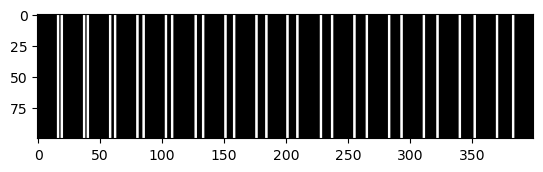

In [164]:
# 后面用更好的替代
# im = io.imread("../tests/image/blurred/blurred_image_2.tif")
im= generate_v_resolution_test_array(
    height=100,
    width=400,
    num_pairs=15,
    min_spacing=1,
    max_spacing=11,
    line_width=2,
    line_value=255,
)
# imtype = im.dtype
im = np.float32(im)+ 1e-3
plt.figure()
plt.imshow(im, cmap="gray")
plt.show()


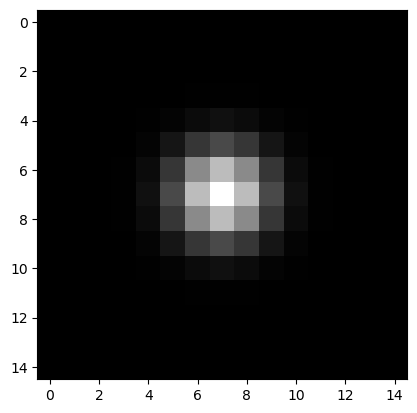

In [165]:
import sparse_recon.iterative_deconv
import sparse_recon.iterative_deconv.kernel

sigma = 3
psf = sparse_recon.iterative_deconv.kernel.Gauss(sigma).cpu().numpy()
plt.figure()
plt.imshow(psf, cmap="gray")
plt.show()

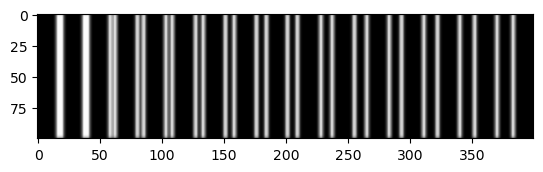

In [166]:
blurred_image = convolve2d(im, psf, mode="same")
plt.figure()
plt.imshow(blurred_image, cmap="gray")
plt.show()

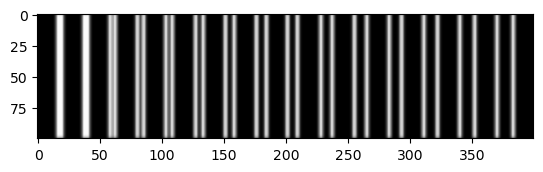

In [167]:
noise_image = (
    np.random.poisson(
        lam=blurred_image / np.max(blurred_image) * 1000, size=blurred_image.shape
    )
    / 1000
    + blurred_image
)
plt.figure()
plt.imshow(noise_image, cmap="gray")
plt.show()

In [168]:
noise_image = torch.tensor(noise_image, device="cuda")
img_recon = sparse_deconv(noise_image, sigma=5,sparse_iter=150)

Start the Sparse deconvolution...
sparse-hessian time 1.59s
deconv time0.02s


In [169]:
img_recon = img_recon.squeeze(0).squeeze(0)
img_recon = img_recon.detach().cpu().numpy()

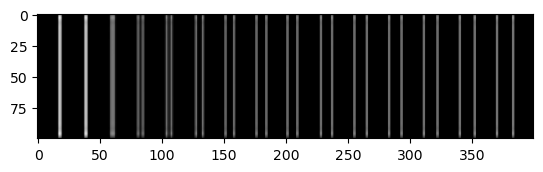

In [170]:
plt.figure()
plt.imshow(img_recon / img_recon.max() * 255, cmap="gray")
plt.show()
# io.imsave("../tests/image/final/test_processed_3.tif", img_recon.astype(imtype))

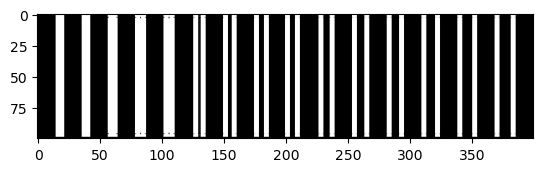

In [171]:
plt.figure()
img_recon_RL = skimage.restoration.richardson_lucy(image=noise_image.cpu().numpy(), psf=psf,num_iter=150)
plt.imshow(img_recon_RL/img_recon_RL.max()  * 255, cmap="gray")
plt.show()

In [172]:
img_recon_RL = img_recon_RL / img_recon_RL.max() * 255
RL_plot_data = img_recon_RL[img_recon_RL.shape[0]//2,:]
size_1_RL= np.arange(img_recon_RL.shape[1])
img_recon_SD = img_recon / img_recon.max() *255
SD_plot_data = img_recon_SD[img_recon_SD.shape[0]//2,:]
size_1_SD = np.arange(img_recon_SD.shape[1])

<Figure size 640x480 with 0 Axes>

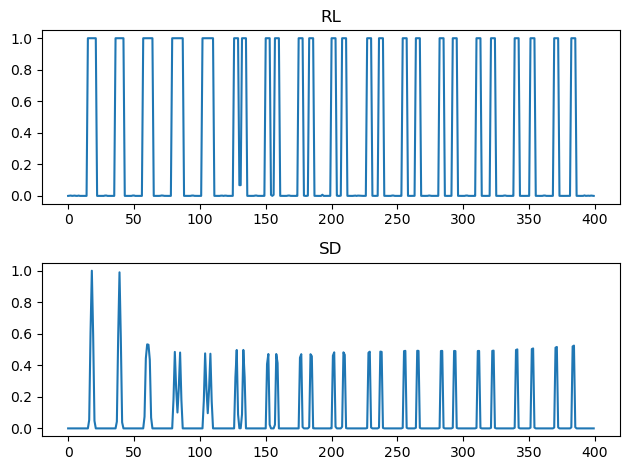

In [173]:


plt.figure()
fig,(ax1,ax2)=plt.subplots(nrows=2,ncols=1)
ax1.plot(size_1_RL,RL_plot_data/np.max(RL_plot_data))
ax1.set_title("RL")
ax2.plot(size_1_SD,SD_plot_data/np.max(SD_plot_data))
ax2.set_title("SD")
plt.tight_layout()
plt.show()